# Assignment 3: Neural Networks and Embeddings
In this assignment, you will apply some of the techniques you learned in class to build a performant sentiment analysis model and compare performance across approaches.

This dataset comes from [Mass et. al. (2011)](https://www.aclweb.org/anthology/P11-1015.pdf) and the full version is available [here](http://ai.stanford.edu/~amaas/data/sentiment/).

In [1]:
# doing this to avoid some warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
# setup
import sys
import subprocess
import pkg_resources
from collections import Counter
import re


required = {'spacy', 'scikit-learn', 'numpy', 'pandas', 'torch', 'matplotlib'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import spacy
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import pickle

from spacy.lang.en import English
en = English()

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
device = torch.device("cpu")

def simple_tokenizer(doc, model=en):
    # a simple tokenizer for individual documents (different from above)
    tokenized_docs = []
    parsed = model(doc)
    return([t.lower_ for t in parsed if (t.is_alpha)&(not t.like_url)])

### Choosing an embedding
In class, we discussed several options for word embeddings.

- One-hot encoding vectors
- NMF/LDA topics at the word level
- Pre-trained GloVe vectors from SpaCy

These embeddings can compared to one another to assess similarity between words.  We did some of this in the class.  But, a lot of the interesting exploration of these embeddings comes from visualizing them in space.  

In the [word2vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) paper, part of their evaluation of performance is to do some vector algebra (e.g. king-man+woman=queen).  This depends on a clear spatial relationship between word vectors.  Let's evaluate the spatial relationship by plotting some particular words.  Let's do this with GloVe and with our NMF/LDA topic model word embeddings.

Tip: If you're not familiar with [matplotlib](https://matplotlib.org/), you'll likely need to look up how to [put together a scatterplot](https://pythonspot.com/matplotlib-scatterplot) and, additionally, how to [annotate it with text](https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point).

Tip \#2: I'm putting some suggested seed words here, but try and think of your own.  Also feel free to do your own explorations.  Any particularly interesting ones I'll include in class next week.  Be creative here, exploratory data analysis with embeddings is something I don't think gets enough attention.

In [7]:
# you will need to change this to where ever the file is stored
data_location = '../data/assignment_1_reviews.pkl'
with open(data_location, 'rb') as f:
    all_text = pickle.load(f)
neg, pos = all_text.values()
# join all reviews
all_reviews = np.array(neg+pos)
# create binary indicator for positive review
is_positive = np.array([0]*len(neg)+[1]*len(pos))
# set the seed for numpy
np.random.seed(seed=42)
# shuffle, just for safety
shuffled_idxs = np.random.choice(range(len(all_reviews)), size=len(all_reviews),replace=False)
all_reviews = all_reviews[shuffled_idxs]
is_positive = is_positive[shuffled_idxs]
# sample random 70% for fitting model (training)
# we'll also add a validation set, for checking the progress of the model during training
# 30% will be simulating "new observations" (testing)
pct_train = 0.7
train_bool = np.random.random(len(all_reviews))<=pct_train
reviews_train = all_reviews[train_bool]
reviews_test = all_reviews[~train_bool]
is_positive_train = is_positive[train_bool]
is_positive_test = is_positive[~train_bool]
# making a validation set
pct_val = 0.3
val_idxs = np.random.random(size=len(reviews_train))<=pct_val
is_positive_val = is_positive_train[val_idxs]
is_positive_val.shape
reviews_val = reviews_train[val_idxs]
# reconfigure train so that it doesn't include validation
reviews_train = reviews_train[~val_idxs]
is_positive_train = is_positive_train[~val_idxs]
print(len(reviews_train), len(reviews_val), len(reviews_test))
parsed_train = [simple_tokenizer(str(d)) for d in reviews_train]
parsed_val = [simple_tokenizer(str(d)) for d in reviews_val]
parsed_test = [simple_tokenizer(str(d)) for d in reviews_test]

1233 535 731


In [32]:
# this formulation works if you have previously tokenized
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, min_df=0.01)
tfidf = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False, min_df=0.01)
# **important** just fit on trained: prevents information from test in training 
cv_train = cv.fit_transform(parsed_train)
tfidf_train = tfidf.fit_transform(parsed_train)
# get out the vocab (same for tfidf)
vocab = cv.vocabulary_
print("Size of vocab:", len(vocab))

Size of vocab: 1765


In [34]:
# topic models
n_components = 10
nmf = NMF(n_components=n_components)
nmf_vecs = nmf.fit_transform(tfidf_train)
lda = LatentDirichletAllocation(n_components=n_components)
lda_vecs = lda.fit_transform(cv_train)
nmf_words = nmf.components_.T
lda_words = lda.components_.T

In [9]:
import en_core_web_md
nlp = en_core_web_md.load()

In [14]:
# get vectors for vocab
glove_vecs = np.zeros(shape=(len(vocab), 300))
for k, v in vocab.items():
    glove_vecs[v] = nlp(k).vector

In [12]:
# plotting
import matplotlib.pyplot as plt

In [15]:
from sklearn.manifold import TSNE

In [23]:
# just using seed words
seeds = ['good', 'bad', 'great',
         'actor', 'actress', 'acting',
        'horror', 'comedy',
        'drama', 'action']
seed_idxs = [vocab[s] for s in seeds]

In [35]:
def plot_vecs(vecs):
    transformed = TSNE().fit_transform(vecs)
    fig, ax = plt.subplots()
    ax.scatter(transformed[seed_idxs,0], 
                transformed[seed_idxs,1])

    for i, txt in enumerate(seeds):
        coords = transformed[seed_idxs[i]]
        ax.annotate(txt, (coords[0], coords[1]))

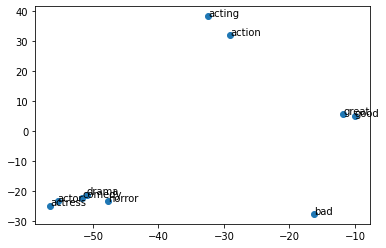

In [36]:
plot_vecs(glove_vecs)

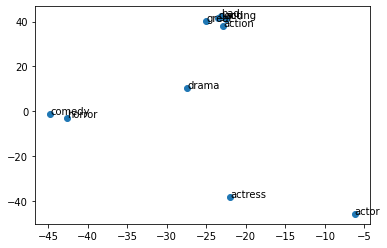

In [37]:
plot_vecs(nmf_words)

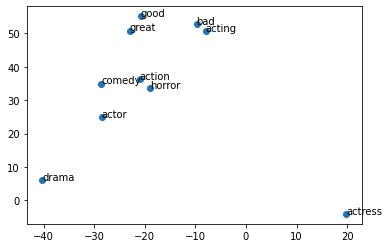

In [38]:
plot_vecs(lda_words)

What have you learned from this exercise? How does the GloVe vector representation match what you'd expect? How about the NMF/LDA representations? Do you have any sense why this might be? 

Include your response here

### LSTM sentiment prediction model
During classes this week, we went through the code below for designing and training an LSTM model for predicting sentiment.  We outlined some of the parameters that can be tweaked in this design.  Try tweaking some of these parameters and assessing the results.

Suggested tweaks:
- NN models tend to perform better with more iterations through the data.  Try increasing the number of epochs of training
- Dropout is one way to reduce overfitting in the model.  Try and tweak the dropout rate and see how it affects loss and accuracy
- Smaller batch sizes may also be a way to avoid overfitting.  Try and tweak the batch size and assess
- Learning rate adjusts how much the model learns from any given batch.  Increasing it might reduce training time.  Decreasing it might reduce overfitting.  Tweak it and see.

In [88]:
def doc_to_index(docs, vocab):
    # transform docs into series of indices
    docs_idxs = []
    for d in docs:
        w_idxs = []
        for w in d:
            if w in vocab:
                w_idxs.append(vocab[w])
            else:
                # unknown token = 1
                w_idxs.append(1)
        docs_idxs.append(w_idxs)
    return(docs_idxs)

def pad_sequence(seqs, seq_len=200):
    # function for adding padding to ensure all seq same length
    features = np.zeros((len(seqs), seq_len),dtype=int)
    for i, seq in enumerate(seqs):
        if len(seq) != 0:
            features[i, -len(seq):] = np.array(seq)[:seq_len]
    return features

def glove_lookup(data, glove_vecs, seq_len=200):
    # given dataset and vectors, turn into array of vectors
    glove_data = np.zeros((len(data), seq_len, 300),
                          dtype='float32')
    for i, d in enumerate(data):
        for ii, w in enumerate(d):
            glove_data[i, ii] = glove_vecs[w]
    return(glove_data)

class SentimentNet(nn.Module):
    # sentiment classifier with single LSTM layer + Fully-connected layer, sigmoid activation and dropout
    # adapted from https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/
    def __init__(self, vocab_size=None, 
                 output_size=1, 
                 embedding_dim=400, 
                 hidden_dim=512, 
                 n_layers=1, 
                 dropout_prob=0.5):
        super(SentimentNet, self).__init__()
        if vocab_size is None:
            raise ValueError('Vocab size cannot be None')
        # size of the output, in this case it's one input to one output
        self.output_size = output_size
        # number of layers = 2, one LSTM layer, one fully-connected layer
        self.n_layers = n_layers
        # dimensions of our hidden state, what is passed from one time point to the next
        self.hidden_dim = hidden_dim
        # LSTM layer, where the magic happens
        self.lstm = nn.LSTM(vocab_size, hidden_dim, n_layers, 
                            dropout=dropout_prob, batch_first=True)
        # dropout, similar to regularization
        self.dropout = nn.Dropout(dropout_prob)
        # fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        # sigmoid activiation
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        # forward pass of the network
        batch_size = x.size(0)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        # initializes the hidden state
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))
        return hidden
    
def train_model(model, train_loader, val_loader, model_params, training_params):
    # utility for running the training process
    model = SentimentNet(**model_params)
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=training_params['learning_rate'])
    epochs = training_params['epochs']
    batch_size = training_params['batch_size']
    # print options
    counter = 0
    print_every = 5
    clip = 5
    valid_loss_min = np.Inf
    model.train()
    for i in range(epochs):
        h = model.init_hidden(batch_size)
        for inputs, labels in train_loader:
            counter += 1
            h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)
            model.zero_grad()
            output, h = model(inputs, h)
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            if counter%print_every == 0:
                val_h = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                for inp, lab in val_loader:
                    val_h = tuple([each.data for each in val_h])
                    inp, lab = inp.to(device), lab.to(device)
                    out, val_h = model(inp, val_h)
                    val_loss = criterion(out.squeeze(), lab.float())
                    val_losses.append(val_loss.item())

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), './state_dict.pt')
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                    valid_loss_min = np.mean(val_losses)
    return(model)
    
def assess_accuracy(model, test_loader, model_params, training_params):
    # utility for assessing accuracy
    batch_size = training_params['batch_size']
    # need to initialize model before loading last state
    model = model(**model_params)
    model.load_state_dict(torch.load('./state_dict.pt'))
    h = model.init_hidden(batch_size)
    num_correct = 0
    model.eval()
    for inputs, labels in test_loader:
        h = tuple([each.data for each in h])
        inputs, labels = inputs.to(device), labels.to(device)
        output, h = model(inputs, h)
        # takes output, rounds to 0/1
        pred = torch.round(output.squeeze())
        # take the correct labels, check against preds
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        # sum the number of correct
        num_correct += np.sum(correct)
    # calc accuracy
    test_acc = num_correct/len(test_loader.dataset)
    print('LSTM accuracy:', test_acc)

In [72]:
# need to adapt vocab, leave space for padding
vocab = dict([(v, vocab[v]+2) for v in vocab])
vocab['_UNK'] = 1
vocab['_PAD'] = 0
parsed_train = doc_to_index(parsed_train, vocab)
padded_train = pad_sequence(parsed_train)
parsed_val = doc_to_index(parsed_val, vocab)
padded_val = pad_sequence(parsed_val)
parsed_test = doc_to_index(parsed_test, vocab)
padded_test = pad_sequence(parsed_test)
# glove lookup
glove_train = glove_lookup(padded_train, glove_vecs)
glove_val = glove_lookup(padded_val, glove_vecs)
glove_test = glove_lookup(padded_test, glove_vecs)
# construct datasets for loading by PyTorch
train_data = TensorDataset(torch.from_numpy(glove_train), torch.from_numpy(is_positive_train))
val_data = TensorDataset(torch.from_numpy(glove_val), torch.from_numpy(is_positive_val))
test_data = TensorDataset(torch.from_numpy(glove_test), torch.from_numpy(is_positive_test))

batch_size = 100

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,
                         drop_last=True) # this is to keep the size consistent
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size,
                       drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,
                        drop_last=True)

In [90]:
model_params = {'vocab_size': 300, # remember: this is the size of the word vector
               'output_size': 1,
               'hidden_dim': 512,
               'n_layers': 2,
               'embedding_dim': 400,
               'dropout_prob': 0.20}
training_params = {'learning_rate': 0.005,
                  'epochs': 1,
                  'batch_size': 100}

In [76]:
train_model(SentimentNet, train_loader, val_loader, model_params, training_params)

Epoch: 1/1... Step: 5... Loss: 0.715454... Val Loss: 0.716019
Validation loss decreased (inf --> 0.716019).  Saving model ...
Epoch: 1/1... Step: 10... Loss: 0.707740... Val Loss: 0.693824
Validation loss decreased (0.716019 --> 0.693824).  Saving model ...


In [91]:
assess_accuracy(SentimentNet, test_loader, model_params, training_params)

LSTM accuracy: 0.46238030095759236
